## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # 另一個繪圖-樣式套件
plt.style.use('ggplot')

### 之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

In [3]:
set(app_train.dtypes)    

{dtype('bool'), dtype('uint8'), dtype('int64'), dtype('float64')}

In [4]:
# Find continuous variables to plot KDE
app_train.nunique()[app_train.nunique()>50]

SK_ID_CURR                      307511
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13672
AMT_GOODS_PRICE                   1002
REGION_POPULATION_RELATIVE          81
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12573
DAYS_REGISTRATION                15688
DAYS_ID_PUBLISH                   6168
OWN_CAR_AGE                         62
EXT_SOURCE_1                    114584
EXT_SOURCE_2                    119831
EXT_SOURCE_3                       814
APARTMENTS_AVG                    2339
BASEMENTAREA_AVG                  3780
YEARS_BEGINEXPLUATATION_AVG        285
YEARS_BUILD_AVG                    149
COMMONAREA_AVG                    3181
ELEVATORS_AVG                      257
ENTRANCES_AVG                      285
FLOORSMAX_AVG                      403
FLOORSMIN_AVG                      305
LANDAREA_AVG                      3527
LIVINGAPARTMENTS_AVG              1868
LIVINGAREA_AVG           

In [5]:
app_train.nunique()[app_train.nunique()==2]

TARGET                                      2
NAME_CONTRACT_TYPE                          2
FLAG_OWN_CAR                                2
FLAG_OWN_REALTY                             2
FLAG_MOBIL                                  2
FLAG_EMP_PHONE                              2
FLAG_WORK_PHONE                             2
FLAG_CONT_MOBILE                            2
FLAG_PHONE                                  2
FLAG_EMAIL                                  2
REG_REGION_NOT_LIVE_REGION                  2
REG_REGION_NOT_WORK_REGION                  2
LIVE_REGION_NOT_WORK_REGION                 2
REG_CITY_NOT_LIVE_CITY                      2
REG_CITY_NOT_WORK_CITY                      2
LIVE_CITY_NOT_WORK_CITY                     2
FLAG_DOCUMENT_2                             2
FLAG_DOCUMENT_3                             2
FLAG_DOCUMENT_4                             2
FLAG_DOCUMENT_5                             2
FLAG_DOCUMENT_6                             2
FLAG_DOCUMENT_7                   

## YEARS_EMPLOYED vs. FLAG_OWN_REALTY

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: YEARS_EMPLOYED, dtype: float64




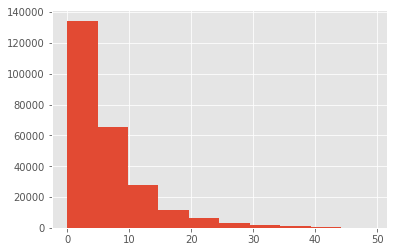

In [6]:
app_train['YEARS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED']) / 365
print(app_train['YEARS_EMPLOYED'].describe())
print('\r\n')

app_train['YEARS_EMPLOYED'].hist()

In [7]:
app_train['YEARS_BINNED'] = pd.qcut(app_train[~app_train.DAYS_EMPLOYED.isna()]['YEARS_EMPLOYED'], 5)
print(app_train['YEARS_BINNED'].value_counts())

(-0.001, 1.69]      50511
(10.071, 49.074]    50428
(1.69, 3.425]       50409
(5.918, 10.071]     50399
(3.425, 5.918]      50390
Name: YEARS_BINNED, dtype: int64


C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


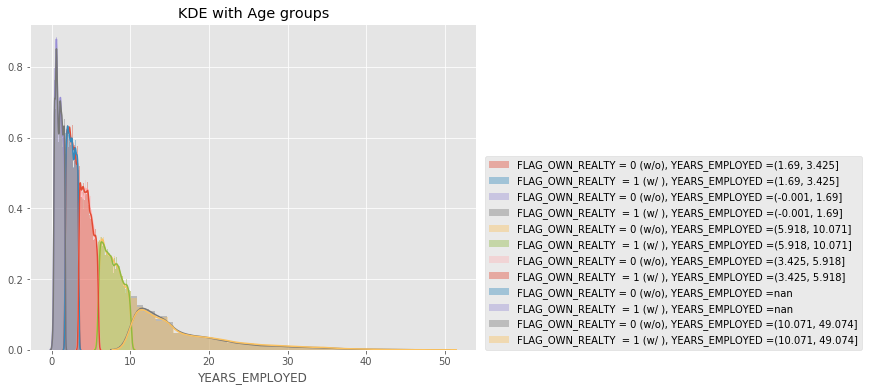

In [8]:
year_group_sorted = app_train['YEARS_BINNED'].unique()

plt.figure(figsize=(8,6))
for i in range(len(year_group_sorted)):
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['FLAG_OWN_REALTY'] == 0), 'YEARS_EMPLOYED'], 
                 label = 'FLAG_OWN_REALTY = 0 (w/o), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
    
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['FLAG_OWN_REALTY'] == 1), 'YEARS_EMPLOYED'], 
                 label = 'FLAG_OWN_REALTY  = 1 (w/ ), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
plt.legend(loc=(1.02, 0))
plt.title('KDE with Age groups')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


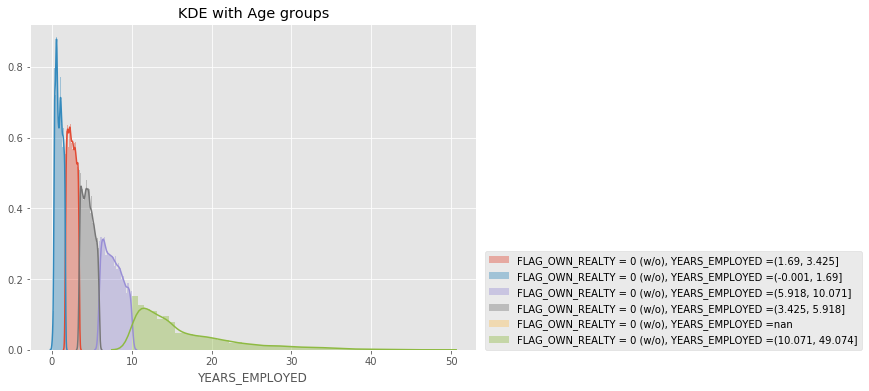

In [9]:
year_group_sorted = app_train['YEARS_BINNED'].unique()

plt.figure(figsize=(8,6))
for i in range(len(year_group_sorted)):
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['FLAG_OWN_REALTY'] == 0), 'YEARS_EMPLOYED'], 
                 label = 'FLAG_OWN_REALTY = 0 (w/o), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
plt.legend(loc=(1.02, 0))
plt.title('KDE with Age groups')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


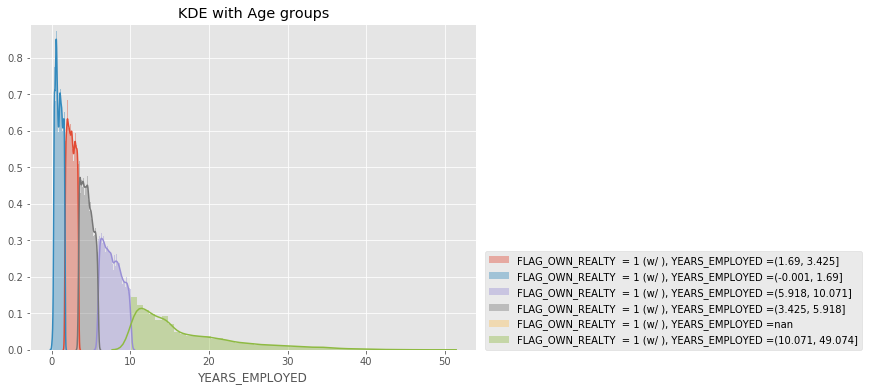

In [10]:
year_group_sorted = app_train['YEARS_BINNED'].unique()

plt.figure(figsize=(8,6))
for i in range(len(year_group_sorted)):    
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['FLAG_OWN_REALTY'] == 1), 'YEARS_EMPLOYED'], 
                 label = 'FLAG_OWN_REALTY  = 1 (w/ ), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
plt.legend(loc=(1.02, 0))
plt.title('KDE with Age groups')
plt.show()

## YEARS_EMPLOYED vs. ORGANIZATION_TYPE_University

C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


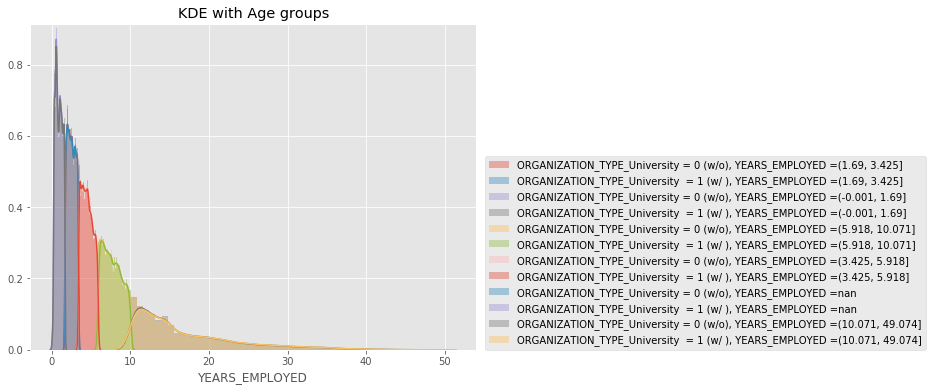

In [11]:
year_group_sorted = app_train['YEARS_BINNED'].unique()

plt.figure(figsize=(8,6))
for i in range(len(year_group_sorted)):
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['ORGANIZATION_TYPE_University'] == 0), 'YEARS_EMPLOYED'], 
                 label = 'ORGANIZATION_TYPE_University = 0 (w/o), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
    
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['FLAG_OWN_REALTY'] == 1), 'YEARS_EMPLOYED'], 
                 label = 'ORGANIZATION_TYPE_University  = 1 (w/ ), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
plt.legend(loc=(1.02, 0))
plt.title('KDE with Age groups')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


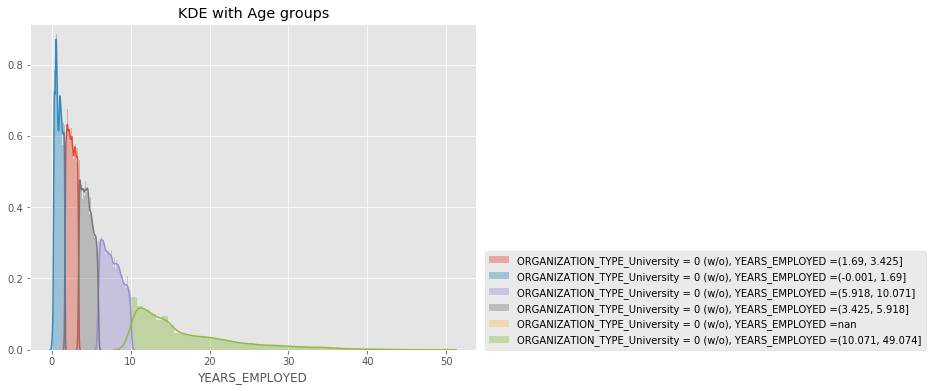

In [12]:
year_group_sorted = app_train['YEARS_BINNED'].unique()

plt.figure(figsize=(8,6))
for i in range(len(year_group_sorted)):
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['ORGANIZATION_TYPE_University'] == 0), 'YEARS_EMPLOYED'], 
                 label = 'ORGANIZATION_TYPE_University = 0 (w/o), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
plt.legend(loc=(1.02, 0))
plt.title('KDE with Age groups')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


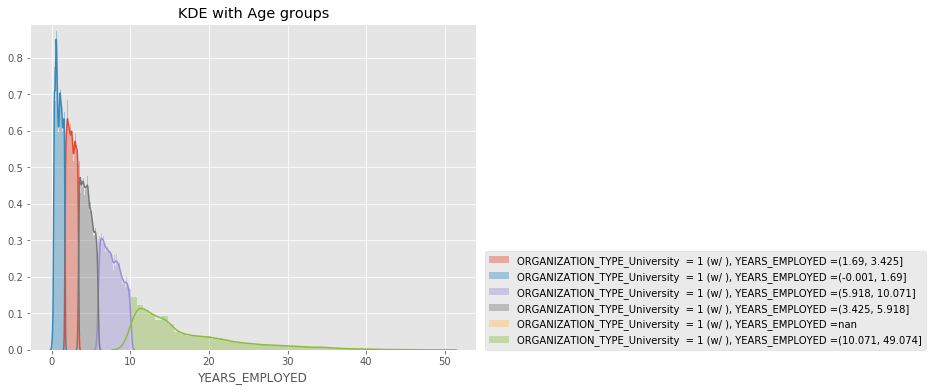

In [13]:
year_group_sorted = app_train['YEARS_BINNED'].unique()

plt.figure(figsize=(8,6))
for i in range(len(year_group_sorted)):
    sns.distplot(app_train.loc[(app_train['YEARS_BINNED'] == year_group_sorted[i]) & \
                               (app_train['FLAG_OWN_REALTY'] == 1), 'YEARS_EMPLOYED'], 
                 label = 'ORGANIZATION_TYPE_University  = 1 (w/ ), YEARS_EMPLOYED =' + str(year_group_sorted[i]))
plt.legend(loc=(1.02, 0))
plt.title('KDE with Age groups')
plt.show()